# Optimización de Cartera por Tracking Error

## Gestor Cuantitativo - Cartera Relativa al Benchmark

Optimización de portafolio maximizando Sharpe ratio relativo vs índice de referencia.

## Instalación de Dependencias

Ejecutar esta celda si es la primera vez que usas el notebook:

```bash
pip install pandas numpy matplotlib seaborn scipy
```

Librerías requeridas:
- pandas: Manipulación de datos
- numpy: Cálculos numéricos
- scipy: Optimización
- matplotlib: Visualización
- seaborn: Gráficos avanzados

In [1]:
import sys
sys.path.insert(0, '../codigo')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tracking_error_portfolio import (
    cargar_datos,
    calcular_estadisticas,
    optimizar_tracking_error,
    calcular_performance_portafolio,
    resumen_portafolio
)
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('[OK] Librerias importadas exitosamente')

[OK] Librerias importadas exitosamente


## 1. Carga de Datos

Cargar retornos de activos y benchmark desde archivos CSV o DataFrames.

In [2]:
datos_retornos = pd.read_excel('../../data/prod_long_sharpe_u60_20260125_v1_train_dataset.csv', sheet_name='Sheet1')
datos_retornos.columns = [f'Activo_{i}' for i in range(1, 61)]

indice_retornos = pd.read_excel('../../data/prod_long_sharpe_u60_20260125_v1_train_dataset.csv', sheet_name='Indice')
benchmark_retornos = indice_retornos.iloc[:, 0]

print(f'[OK] Datos cargados')
print(f'[OK] Retornos activos: {datos_retornos.shape}')
print(f'[OK] Retorno benchmark: {benchmark_retornos.shape}')
print(f'[OK] Período: {len(datos_retornos)} observaciones')
print()
print(f'Primeras filas de activos:')
print(datos_retornos.head())

[OK] Datos cargados
[OK] Retornos activos: (1758, 60)
[OK] Retorno benchmark: (1758,)
[OK] Período: 1758 observaciones

Primeras filas de activos:
   Activo_1  Activo_2  Activo_3  Activo_4  Activo_5  Activo_6  Activo_7  \
0 -0.028988  0.000000  0.011857 -0.052465 -0.044951 -0.001556 -0.061189   
1 -0.001839 -0.009662  0.036648  0.002373  0.028330  0.060441  0.010914   
2  0.034392  0.013261  0.005665  0.030049  0.090729  0.010211  0.082024   
3  0.010620  0.022500  0.013097  0.072178 -0.003407  0.028614 -0.026600   
4 -0.007067  0.024293 -0.003725 -0.017852 -0.040040 -0.014205 -0.035274   

   Activo_8  Activo_9  Activo_10  ...  Activo_51  Activo_52  Activo_53  \
0 -0.022658 -0.070095  -0.078670  ...  -0.011112  -0.060292  -0.001453   
1  0.042820  0.067410  -0.006427  ...   0.008345   0.015417   0.000000   
2  0.020742  0.043399   0.013692  ...   0.024625  -0.019566   0.059256   
3  0.055147  0.109022   0.136664  ...   0.042334   0.008534  -0.006873   
4 -0.038666  0.098296  -0.011009

## 2. Estadísticas Descriptivas

Análisis de retornos y volatilidades de activos vs benchmark.

In [3]:
retorno_diario_promedio = datos_retornos.mean()
volatilidad_diaria = datos_retornos.std()

retorno_anual_activos = retorno_diario_promedio * 252
volatilidad_anual_activos = volatilidad_diaria * np.sqrt(252)

retorno_anual_benchmark = benchmark_retornos.mean() * 252
volatilidad_anual_benchmark = benchmark_retornos.std() * np.sqrt(252)

print('[ESTADISTICAS ANUALIZADAS]')
print()
print(f'Benchmark:')
print(f'  Retorno: {retorno_anual_benchmark:.4f} ({retorno_anual_benchmark*100:.2f}%)')
print(f'  Volatilidad: {volatilidad_anual_benchmark:.4f} ({volatilidad_anual_benchmark*100:.2f}%)')
print()
print(f'Activos - Resumen:')
print(f'  Retorno promedio: {retorno_anual_activos.mean():.4f} ({retorno_anual_activos.mean()*100:.2f}%)')
print(f'  Volatilidad promedio: {volatilidad_anual_activos.mean():.4f} ({volatilidad_anual_activos.mean()*100:.2f}%)')
print(f'  Retorno mínimo: {retorno_anual_activos.min():.4f} ({retorno_anual_activos.min()*100:.2f}%)')
print(f'  Retorno máximo: {retorno_anual_activos.max():.4f} ({retorno_anual_activos.max()*100:.2f}%)')
print()
print('Top 5 activos por retorno anualizado:')
top_retorno = retorno_anual_activos.nlargest(5)
for activo, retorno in top_retorno.items():
    print(f'  {activo}: {retorno:.4f} ({retorno*100:.2f}%)')

[ESTADISTICAS ANUALIZADAS]

Benchmark:
  Retorno: 0.0064 (0.64%)
  Volatilidad: 0.1818 (18.18%)

Activos - Resumen:
  Retorno promedio: 0.0747 (7.47%)
  Volatilidad promedio: 0.3131 (31.31%)
  Retorno mínimo: -0.1562 (-15.62%)
  Retorno máximo: 0.3032 (30.32%)

Top 5 activos por retorno anualizado:
  Activo_22: 0.3032 (30.32%)
  Activo_51: 0.2734 (27.34%)
  Activo_43: 0.2509 (25.09%)
  Activo_48: 0.2506 (25.06%)
  Activo_56: 0.2421 (24.21%)


## 3. Optimización por Tracking Error

Ejecuta la optimización de cartera maximizando Sharpe ratio relativo.

In [4]:
resultado_opt = optimizar_tracking_error(datos_retornos, benchmark_retornos, verbose=True)

pesos_optimos = resultado_opt['pesos']
print()
print('[METRICAS DE LA CARTERA OPTIMIZADA]')
print(f'Retorno esperado: {resultado_opt["retorno_esperado"]:.4f} ({resultado_opt["retorno_esperado"]*100:.2f}%)')
print(f'Tracking error: {resultado_opt["tracking_error"]:.4f} ({resultado_opt["tracking_error"]*100:.2f}%)')
print(f'Sharpe relativo: {resultado_opt["sharpe_relativo"]:.4f}')
print(f'Excess return: {resultado_opt["excess_return"]:.4f} ({resultado_opt["excess_return"]*100:.2f}%)')
print(f'Status: {resultado_opt["status"]}')

[OK] Optimizacion completada
Retorno esperado portafolio: 0.1577 (15.77%)
Tracking error anualizado: 0.0743 (7.43%)
Sharpe relativo: 2.0362
Excess return: 0.1512 (15.12%)
Retorno benchmark: 0.0064 (0.64%)

[METRICAS DE LA CARTERA OPTIMIZADA]
Retorno esperado: 0.1577 (15.77%)
Tracking error: 0.0743 (7.43%)
Sharpe relativo: 2.0362
Excess return: 0.1512 (15.12%)
Status: success


## 4. Pesos Óptimos

Distribución de pesos del portafolio optimizado.

In [9]:
resumen_df = resumen_portafolio(datos_retornos, pesos_optimos)

print('[PESOS OPTIMOS - ACTIVOS CON PESO > 0.1%]')
print()
print(resumen_df.to_string(index=False))
print()
print(f'Total activos en cartera: {len(resumen_df)}')
print(f'Suma de pesos: {resumen_df["Peso"].sum():.4f}')

pesos_redondeados = [round(p, 3) for p in pesos_optimos]
print()
print('[VECTOR DE PESOS - 60 ACTIVOS (redondeado a 3 decimales)]')
print(pesos_redondeados)

[PESOS OPTIMOS - ACTIVOS CON PESO > 0.1%]

   Activo     Peso  Peso_Porcentaje
Activo_51 0.124452        12.445247
Activo_48 0.092749         9.274896
 Activo_7 0.090165         9.016536
Activo_11 0.060809         6.080887
Activo_56 0.057815         5.781514
Activo_22 0.057351         5.735095
Activo_43 0.056864         5.686363
Activo_42 0.046986         4.698591
Activo_28 0.044040         4.403972
Activo_12 0.043671         4.367108
Activo_41 0.041720         4.172042
 Activo_6 0.039394         3.939392
Activo_24 0.031095         3.109521
Activo_20 0.030382         3.038194
Activo_47 0.027268         2.726822
 Activo_9 0.026974         2.697353
Activo_33 0.025142         2.514190
Activo_50 0.021547         2.154697
Activo_27 0.019891         1.989132
Activo_13 0.013549         1.354912
Activo_40 0.012027         1.202664
Activo_30 0.010941         1.094082
Activo_21 0.006335         0.633493
Activo_52 0.006298         0.629756
Activo_55 0.004465         0.446534
Activo_35 0.004253   

## 5. Análisis de Performance

Comparación de portafolio optimizado vs benchmark en el tiempo.

In [10]:
performance = calcular_performance_portafolio(datos_retornos, benchmark_retornos, pesos_optimos)

retornos_portafolio = performance['retornos_portafolio']
retornos_benchmark = performance['retornos_benchmark']
tracking_error_dinamico = performance['tracking_error_dinamico']
valor_portafolio = performance['valor_portafolio']
valor_benchmark = performance['valor_benchmark']

print('[METRICAS DE PERFORMANCE]')
print()
print(f'Retorno acumulado portafolio: {(valor_portafolio[-1] - 1)*100:.2f}%')
print(f'Retorno acumulado benchmark: {(valor_benchmark[-1] - 1)*100:.2f}%')
print(f'Outperformance acumulado: {((valor_portafolio[-1] / valor_benchmark[-1]) - 1)*100:.2f}%')
print()
print(f'Volatilidad portafolio: {np.std(retornos_portafolio)*np.sqrt(252)*100:.2f}%')
print(f'Volatilidad benchmark: {np.std(retornos_benchmark)*np.sqrt(252)*100:.2f}%')
print()
print(f'Tracking error (std): {np.std(tracking_error_dinamico)*np.sqrt(252)*100:.2f}%')
print(f'Tracking error (promedio): {np.mean(tracking_error_dinamico)*252*100:.2f}%')

[METRICAS DE PERFORMANCE]

Retorno acumulado portafolio: 171.39%
Retorno acumulado benchmark: -6.79%
Outperformance acumulado: 191.15%

Volatilidad portafolio: 17.04%
Volatilidad benchmark: 18.18%

Tracking error (std): 7.42%
Tracking error (promedio): 15.12%


## 6. Visualizaciones

Gráficos de comparación portafolio vs benchmark.

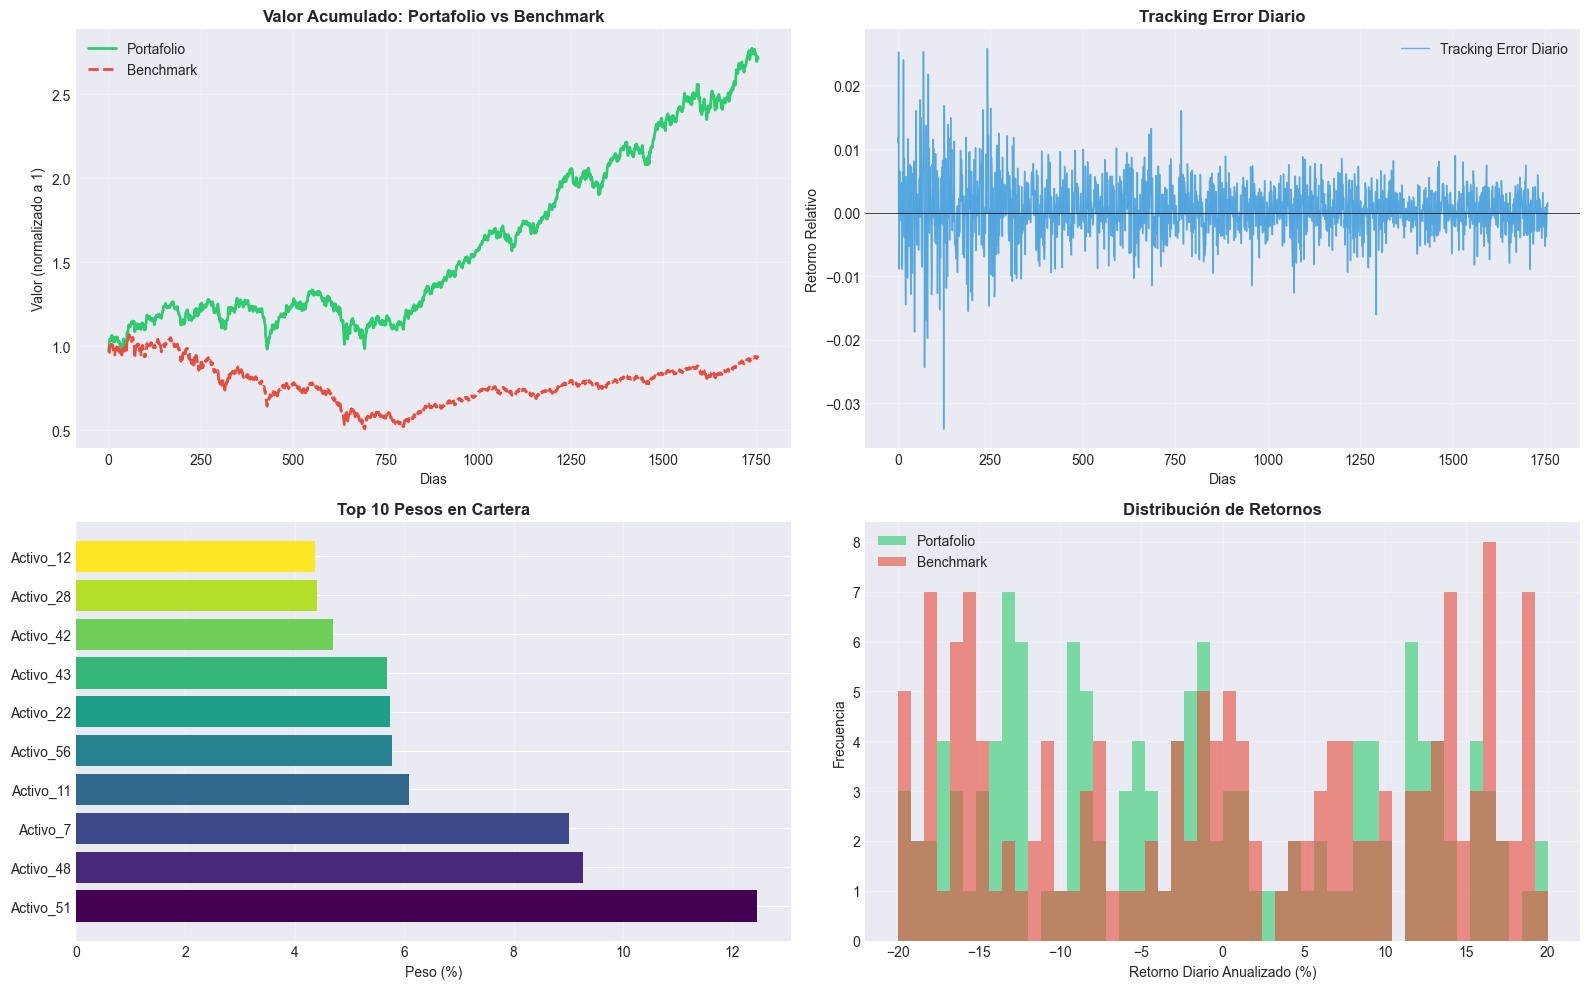

[OK] Gráficos guardados: tracking_error_analysis.png


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(valor_portafolio, label='Portafolio', linewidth=2, color='#2ecc71')
axes[0, 0].plot(valor_benchmark, label='Benchmark', linewidth=2, color='#e74c3c', linestyle='--')
axes[0, 0].set_title('Valor Acumulado: Portafolio vs Benchmark', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Dias')
axes[0, 0].set_ylabel('Valor (normalizado a 1)')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(tracking_error_dinamico, label='Tracking Error Diario', linewidth=1, color='#3498db', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].fill_between(range(len(tracking_error_dinamico)), tracking_error_dinamico, 0, alpha=0.3, color='#3498db')
axes[0, 1].set_title('Tracking Error Diario', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Dias')
axes[0, 1].set_ylabel('Retorno Relativo')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

pesos_plot = resumen_df.nlargest(10, 'Peso')
colors = plt.cm.viridis(np.linspace(0, 1, len(pesos_plot)))
axes[1, 0].barh(range(len(pesos_plot)), pesos_plot['Peso_Porcentaje'], color=colors)
axes[1, 0].set_yticks(range(len(pesos_plot)))
axes[1, 0].set_yticklabels(pesos_plot['Activo'])
axes[1, 0].set_xlabel('Peso (%)')
axes[1, 0].set_title('Top 10 Pesos en Cartera', fontweight='bold', fontsize=12)
axes[1, 0].grid(axis='x', alpha=0.3)

retorno_hist_p = np.histogram(retornos_portafolio * 252 * 100, bins=50, range=(-20, 20))
retorno_hist_b = np.histogram(retornos_benchmark * 252 * 100, bins=50, range=(-20, 20))

axes[1, 1].hist(retornos_portafolio * 252 * 100, bins=50, alpha=0.6, label='Portafolio', color='#2ecc71', range=(-20, 20))
axes[1, 1].hist(retornos_benchmark * 252 * 100, bins=50, alpha=0.6, label='Benchmark', color='#e74c3c', range=(-20, 20))
axes[1, 1].set_xlabel('Retorno Diario Anualizado (%)')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Retornos', fontweight='bold', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tracking_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('[OK] Gráficos guardados: tracking_error_analysis.png')

## 7. Exportación de Resultados

Guardado de pesos óptimos en CSV.

In [8]:
df_export = pd.DataFrame({
    'Activo': range(1, 61),
    'Peso': pesos_redondeados,
    'Peso_Porcentaje': [round(p*100, 1) for p in pesos_redondeados]
})

df_export.to_csv('../vector_pesos_tracking_error.csv', index=False)

print('[OK] Pesos exportados: vector_pesos_tracking_error.csv')
print()
print('Vector completo (60 activos):')
print(df_export.to_string(index=False))

[OK] Pesos exportados: vector_pesos_tracking_error.csv

Vector completo (60 activos):
 Activo  Peso  Peso_Porcentaje
      1 0.001              0.1
      2 0.000              0.0
      3 0.000              0.0
      4 0.000              0.0
      5 0.000              0.0
      6 0.039              3.9
      7 0.090              9.0
      8 0.000              0.0
      9 0.027              2.7
     10 0.000              0.0
     11 0.061              6.1
     12 0.044              4.4
     13 0.014              1.4
     14 0.000              0.0
     15 0.000              0.0
     16 0.003              0.3
     17 0.000              0.0
     18 0.000              0.0
     19 0.000              0.0
     20 0.030              3.0
     21 0.006              0.6
     22 0.057              5.7
     23 0.000              0.0
     24 0.031              3.1
     25 0.000              0.0
     26 0.000              0.0
     27 0.020              2.0
     28 0.044              4.4
     29 0.000  